In [1]:
import numpy as np
import control
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load matrices from CSV
A_d = pd.read_csv('data/statespace_models/A_discrete.csv', header=None).values
B_d = pd.read_csv('data/statespace_models/B_discrete.csv', header=None).values
C_d = pd.read_csv('data/statespace_models/C_discrete.csv', header=None).values
D_d = pd.read_csv('data/statespace_models/D_discrete.csv', header=None).values

# Load dt from text file
with open('data/statespace_models/dt_discrete.txt', 'r') as f:
    dt = float(f.read().strip())

# Create the discrete system
sys_d = control.ss(A_d, B_d, C_d, D_d, dt)

In [3]:
# Load observer gains
L_c = pd.read_csv('data/gain_matrices/L_Continuous.csv', header=None).values
L_d = pd.read_csv('data/gain_matrices/L_Discrete.csv', header=None).values

# Load controller gains
K_c = pd.read_csv('data/gain_matrices/K_Continuous.csv', header=None).values
K_d = pd.read_csv('data/gain_matrices/K_Discrete.csv', header=None).values

In [4]:
# Load ekf Q and R
Qn = pd.read_csv('data/nonlinear_matrices/Qn.csv', header=None).values
Rn = pd.read_csv('data/nonlinear_matrices/Rn.csv', header=None).values

# Nonlinear Controller Simulation

In [5]:
# Initial State
x0 = np.array([0.0, 0.0, 0.1, 0.1])

In [6]:
dt = sys_d.dt
T_d = np.arange(0, 10, dt)
t_eval_d = T_d

## Extended Kalman Filter

<p align="center">
  <img src="Diagrams/EKF/EKF.png" alt="Alt text" width="600" height="500"/>
</p>


In [7]:
from utils import ekf_simulation_nonlinear_discrete,ekf_simulation_nonlinear_discrete_v1
# Run simulation
measurement_noise_std = np.array([0.01, 0.01, 0.1, 0.1])
disturbance_std = np.array([0.0, 0.00, 0.01, 0.01])
t_impulse = 3
impulse_magnitude = np.array([0.00, 0.05, 0.2, 0.2])
P0 = np.diag([
    1,  # position variance (m^2)
    1,  # velocity variance (m/s)^2
    1,  # angle variance (rad^2)
    1   # angular velocity variance (rad/s)^2
])

T_ekf_d, x_true_ekf_d, x_hat_ekf_d, tau_ekf_d = ekf_simulation_nonlinear_discrete(
    x0, P0, K_d,t_eval_d, Qn, Rn,
    measurement_noise_std=measurement_noise_std,
    disturbance_std=disturbance_std,
    t_impulse=t_impulse,
    impulse_magnitude=impulse_magnitude,
    low_pass_enabled=False,
    debug_enabled=True)

K:[[0.88410997 1.79032573 4.29572825 1.49447001]]
K:[0.  0.  0.1 0.1]
u_filtered:-0.5790198258109356
[[ 9.99999000e-01  2.99996700e-09  9.94549716e-12 -3.49016655e-14]
 [ 2.99996700e-09  9.99999000e-01 -3.31519887e-09  1.16340048e-11]
 [ 9.94549716e-12 -3.31519887e-09  9.99998988e-01  1.07705435e-07]
 [-3.49016658e-14  1.16340049e-11  1.07705435e-07  9.99998999e-01]]
[[ 5.00001795e-01  1.36363122e-04  1.66984769e-07  1.38236478e-09]
 [ 1.36363122e-04  9.09090888e-01 -1.11323625e-04 -9.21580200e-07]
 [ 1.66984770e-07 -1.11323625e-04  4.99787842e-01  4.41009536e-03]
 [ 1.38236477e-09 -9.21580202e-07  4.41009536e-03  9.09125077e-01]]
[[ 3.33337797e-01  1.74998771e-04  8.16183754e-08  7.53930104e-10]
 [ 1.74998771e-04  9.08333307e-01 -8.16206597e-05 -7.48849334e-07]
 [ 8.16183756e-08 -8.16206597e-05  3.33134911e-01  3.30844063e-03]
 [ 7.53930105e-10 -7.48849334e-07  3.30844063e-03  9.08361311e-01]]
[[ 2.50007266e-01  1.99386812e-04  4.24348529e-08  4.01647204e-10]
 [ 1.99386812e-04  9.0832

0.999999, -0.003000, -0.000010, 0.000000 | -0.003000, 0.999999, 0.003315, -0.000012 | -0.000010, 0.003315, 1.011594, -0.107705 | 0.000000, -0.000012, -0.107705, 1.000637


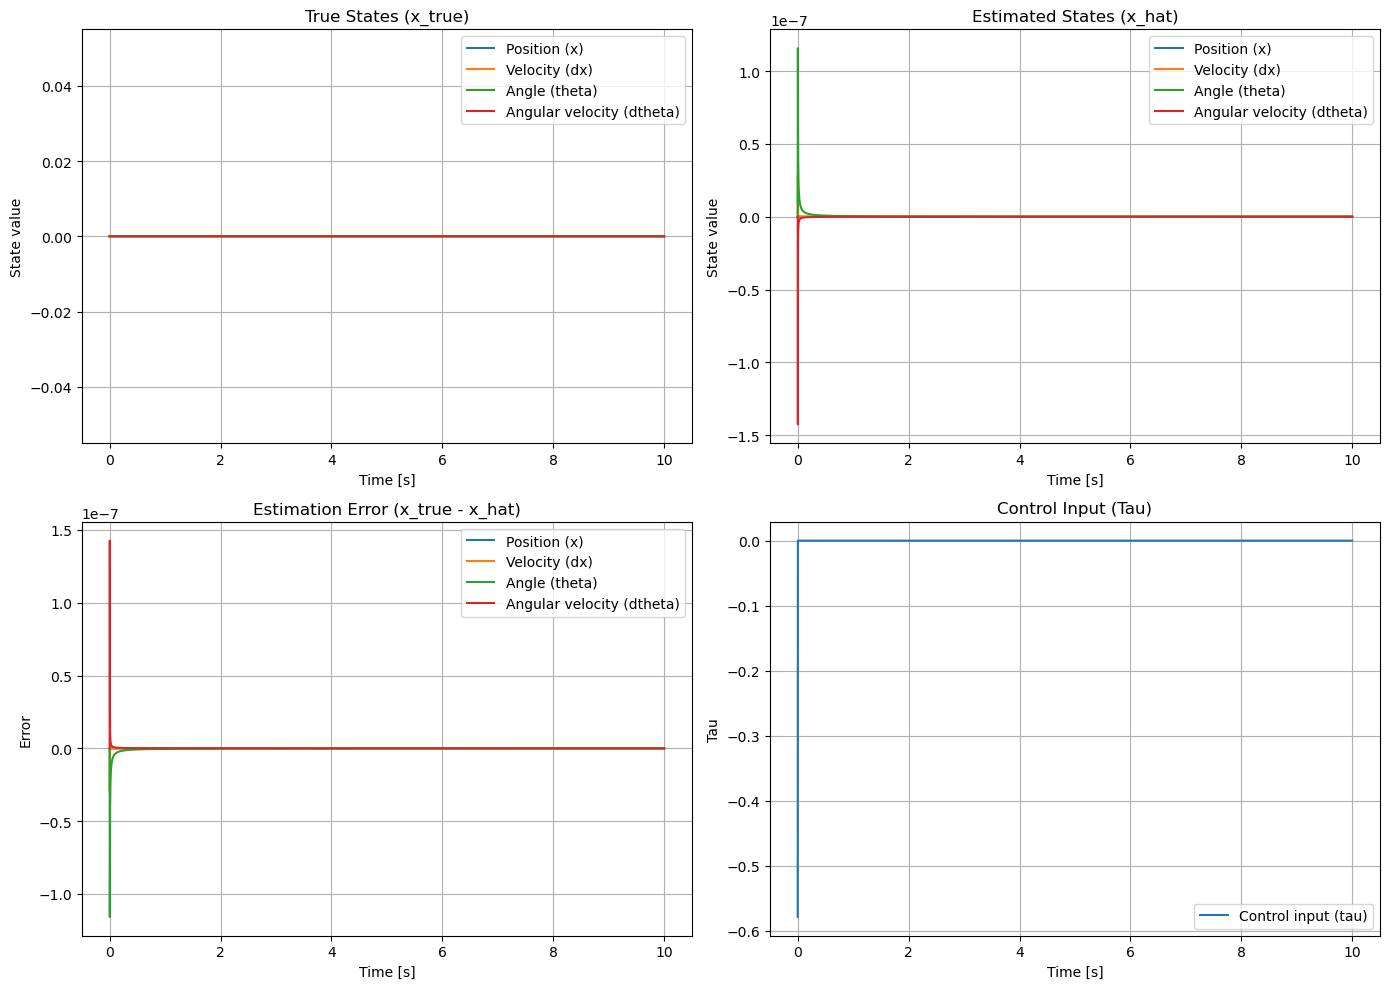

In [8]:
state_labels = ['Position (x)', 'Velocity (dx)', 'Angle (theta)', 'Angular velocity (dtheta)']

plt.figure(figsize=(14, 10))

# True states
plt.subplot(2, 2, 1)
for i in range(4):
    plt.plot(T_ekf_d, x_true_ekf_d[i], label=state_labels[i])
plt.title('True States (x_true)')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Estimated states
plt.subplot(2, 2, 2)
for i in range(4):
    plt.plot(T_ekf_d, x_hat_ekf_d[i], label=state_labels[i])
plt.title('Estimated States (x_hat)')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Estimation error
plt.subplot(2, 2, 3)
for i in range(4):
    plt.plot(T_ekf_d, x_true_ekf_d[i] - x_hat_ekf_d[i], label=state_labels[i])
plt.title('Estimation Error (x_true - x_hat)')
plt.xlabel('Time [s]')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Control input
plt.subplot(2, 2, 4)
plt.plot(T_ekf_d, tau_ekf_d, label='Control input (tau)')
plt.title('Control Input (Tau)')
plt.xlabel('Time [s]')
plt.ylabel('Tau')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


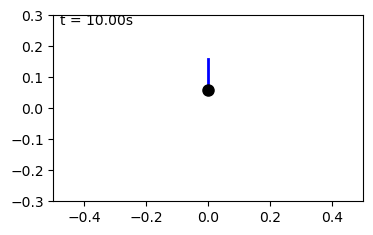

In [9]:
from utils import animate_inverted_pendulum
animate_inverted_pendulum(x_pos=x_true_ekf_d[0], theta = x_true_ekf_d[2], time =t_eval_d)